<a href="https://colab.research.google.com/github/j-will7378/Cookie-Cats-A-B-Test/blob/main/Google__Store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 104.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [10]:
# ─────────────────────────────
# 0.  Install BigQuery client
# ─────────────────────────────
!pip install --quiet google-cloud-bigquery pandas matplotlib seaborn

# ─────────────────────────────
# 1.  Authenticate your Google account
#     (no project ID needed here)
# ─────────────────────────────
from google.colab import auth
auth.authenticate_user()          # browser pops up; pick the SAME account
print("✅  Auth done")

# ─────────────────────────────
# 2.  Build a BigQuery client that
#     bills jobs to YOUR project
# ─────────────────────────────
from google.cloud import bigquery
PROJECT_ID = "cogent-sweep-458308-j7"   # ← your project *ID* (lowercase, unique)
bqclient   = bigquery.Client(project=PROJECT_ID)

print("Jobs will run in →", bqclient.project)

✅  Auth done
Jobs will run in → cogent-sweep-458308-j7


In [11]:
test_sql = """
SELECT event_name, COUNT(*) AS events
FROM   `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20210131`
GROUP  BY event_name
ORDER  BY events DESC
LIMIT  5
"""
df = bqclient.query(test_sql).to_dataframe()
df

,event_name,events
0,page_view,9498
1,user_engagement,5005
2,scroll,2870
3,session_start,2760
4,first_visit,2127


In [12]:
probe_sql = """
SELECT DISTINCT event_name
FROM   `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE  event_name IN ('view_item','add_to_cart','begin_checkout',
                      'add_shipping_info','add_payment_info','purchase')
ORDER  BY event_name
"""
bqclient.query(probe_sql).to_dataframe()

,event_name
0,add_payment_info
1,add_shipping_info
2,add_to_cart
3,begin_checkout
4,purchase
5,view_item


In [14]:
coverage_sql = f"""
WITH base AS (
  SELECT
    event_name,

    -- 🆕 Pull page_location out of event_params, then test for AMP flag
    REGEXP_CONTAINS(
      (SELECT value.string_value
         FROM UNNEST(event_params)
        WHERE key = 'page_location'),
      r'(/amp/|\?amp)'
    )                                               AS is_amp,

    (SELECT value.int_value
       FROM UNNEST(event_params)
      WHERE key = 'ga_session_id')                  AS session_id,

    (SELECT value.string_value
       FROM UNNEST(event_params)
      WHERE key = 'client_id')                      AS client_id,

    (SELECT value.int_value
       FROM UNNEST(event_params)
      WHERE key = 'checkout_step')                  AS checkout_step,

    event_timestamp
  FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
  WHERE _TABLE_SUFFIX BETWEEN '20210101' AND '20210131'
    AND device.category = 'mobile'
    AND event_name IN ('view_item','add_to_cart','begin_checkout',
                       'add_shipping_info','add_payment_info','purchase')
)

SELECT
  event_name,
  is_amp,
  COUNT(*)                                            AS events,
  SAFE_DIVIDE(COUNTIF(event_timestamp IS NOT NULL),   COUNT(*)) AS pct_event_timestamp,
  SAFE_DIVIDE(COUNTIF(session_id      IS NOT NULL),   COUNT(*)) AS pct_session_id,
  SAFE_DIVIDE(COUNTIF(client_id       IS NOT NULL),   COUNT(*)) AS pct_client_id,
  SAFE_DIVIDE(COUNTIF(checkout_step   IS NOT NULL),   COUNT(*)) AS pct_checkout_step
FROM base
GROUP BY event_name, is_amp
ORDER BY event_name, is_amp;
"""
coverage_df = bqclient.query(coverage_sql).to_dataframe()
coverage_df

,event_name,is_amp,events,pct_event_timestamp,pct_session_id,pct_client_id,pct_checkout_step
0,add_payment_info,False,1185,1.0,1.0,0.0,0.0
1,add_shipping_info,False,1654,1.0,1.0,0.0,0.0
2,add_to_cart,False,5980,1.0,1.0,0.0,0.0
3,begin_checkout,False,4575,1.0,1.0,0.0,0.0
4,purchase,False,508,1.0,1.0,0.0,0.0
5,view_item,False,33518,1.0,1.0,0.0,0.0


In [18]:
# 1️⃣  Run the SQL and create the dataframe
retention_sql = """
WITH step_counts AS (
  SELECT
    -- flag AMP vs. non-AMP
    REGEXP_CONTAINS(
      (SELECT value.string_value
         FROM UNNEST(event_params)
        WHERE key = 'page_location'),
      r'(/amp/|\?amp)'
    )                                               AS is_amp,

    event_name,

    -- numeric rank for window ordering
    CASE event_name
      WHEN 'view_item'         THEN 1
      WHEN 'add_to_cart'       THEN 2
      WHEN 'begin_checkout'    THEN 3
      WHEN 'add_shipping_info' THEN 4
      WHEN 'add_payment_info'  THEN 5
      WHEN 'purchase'          THEN 6
    END                                             AS step_num,

    -- proxy for sessions (user × day)
    COUNT(DISTINCT CONCAT(user_pseudo_id,'-', event_date)) AS sessions

  FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
  WHERE _TABLE_SUFFIX BETWEEN '20210101' AND '20210131'        -- 🔁 keep or tweak
    AND device.category = 'mobile'
    AND event_name IN ('view_item','add_to_cart','begin_checkout',
                       'add_shipping_info','add_payment_info','purchase')
  GROUP BY is_amp, event_name, step_num
)

SELECT
  is_amp,
  event_name,
  sessions,
  SAFE_DIVIDE(
      sessions,
      LAG(sessions) OVER (PARTITION BY is_amp ORDER BY step_num)
  ) AS retention_from_prev
FROM step_counts
ORDER BY is_amp, step_num;

"""
retention_df = bqclient.query(retention_sql).to_dataframe()
retention_df.head()

,is_amp,event_name,sessions,retention_from_prev
0,False,view_item,8643,NaN
1,False,add_to_cart,1707,0.197501
2,False,begin_checkout,827,0.484476
3,False,add_shipping_info,827,1.000000
4,False,add_payment_info,613,0.741233


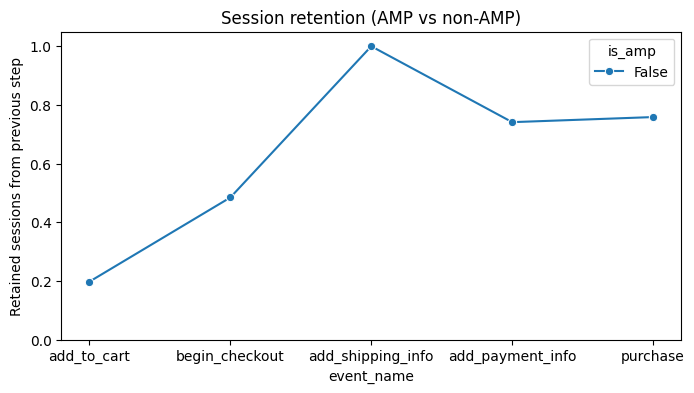

In [19]:
import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sns.lineplot(data=retention_df,
             x='event_name', y='retention_from_prev',
             hue='is_amp', marker='o')
plt.ylim(0,1.05)
plt.ylabel('Retained sessions from previous step')
plt.title('Session retention (AMP vs non-AMP)')
plt.show()